In [ ]:
import datetime
import json
import os
import pathlib

import cv2
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from tensorflow import keras
from tensorflow.keras import Input, Model, layers, models
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tqdm import tqdm

In [24]:
base_path = pathlib.Path(os.getcwd(), "..", "..").resolve()

class Config:
    experiments_path = pathlib.Path(os.path.join(base_path, "experiments", "autoencoder")).resolve()
    dataset_path = pathlib.Path(os.path.join(base_path, "data", "categorized_images", "large")).resolve()
    patience = 25
    epochs = 1000
    batch_size = 8
    encoding_dim = 128
    imgsz = 128
    n_clusters = 4

os.makedirs(Config.experiments_path, exist_ok=True)

In [10]:
def build_autoencoder(input_shape, encoding_dim):
    inputs = tf.keras.Input(shape=input_shape, name="encoder_input")

    # Encoder
    x = tf.keras.layers.Conv2D(
        32, (3, 3), activation="relu", padding="same")(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(
        64, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(
        128, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)

    # Calculate shape before flattening
    shape_before_flattening = x.shape[1:]  # (H, W, C)
    flattened_dim = int(np.prod(shape_before_flattening))  # Convert to integer

    x = tf.keras.layers.Flatten()(x)
    encoded = tf.keras.layers.Dense(
        encoding_dim, activation="relu", name="latent")(x)

    # Decoder
    x_dec = tf.keras.layers.Dense(
        flattened_dim, activation="relu", name="dec_dense")(encoded)
    x_dec = tf.keras.layers.Reshape(shape_before_flattening)(x_dec)
    x_dec = tf.keras.layers.Conv2DTranspose(
        128, (3, 3), strides=2, activation="relu", padding="same")(x_dec)
    x_dec = tf.keras.layers.Conv2DTranspose(
        64, (3, 3), strides=2, activation="relu", padding="same")(x_dec)
    x_dec = tf.keras.layers.Conv2DTranspose(
        32, (3, 3), strides=2, activation="relu", padding="same")(x_dec)
    decoded = tf.keras.layers.Conv2D(
        3, (3, 3), activation="sigmoid", padding="same")(x_dec)

    autoencoder = tf.keras.Model(inputs, decoded, name="autoencoder")
    encoder = tf.keras.Model(inputs, encoded, name="encoder")

    return autoencoder, encoder

In [ ]:
# Build models
autoencoder, encoder = build_autoencoder(
    input_shape=(Config.imgsz, Config.imgsz, 3), encoding_dim=Config.encoding_dim
)

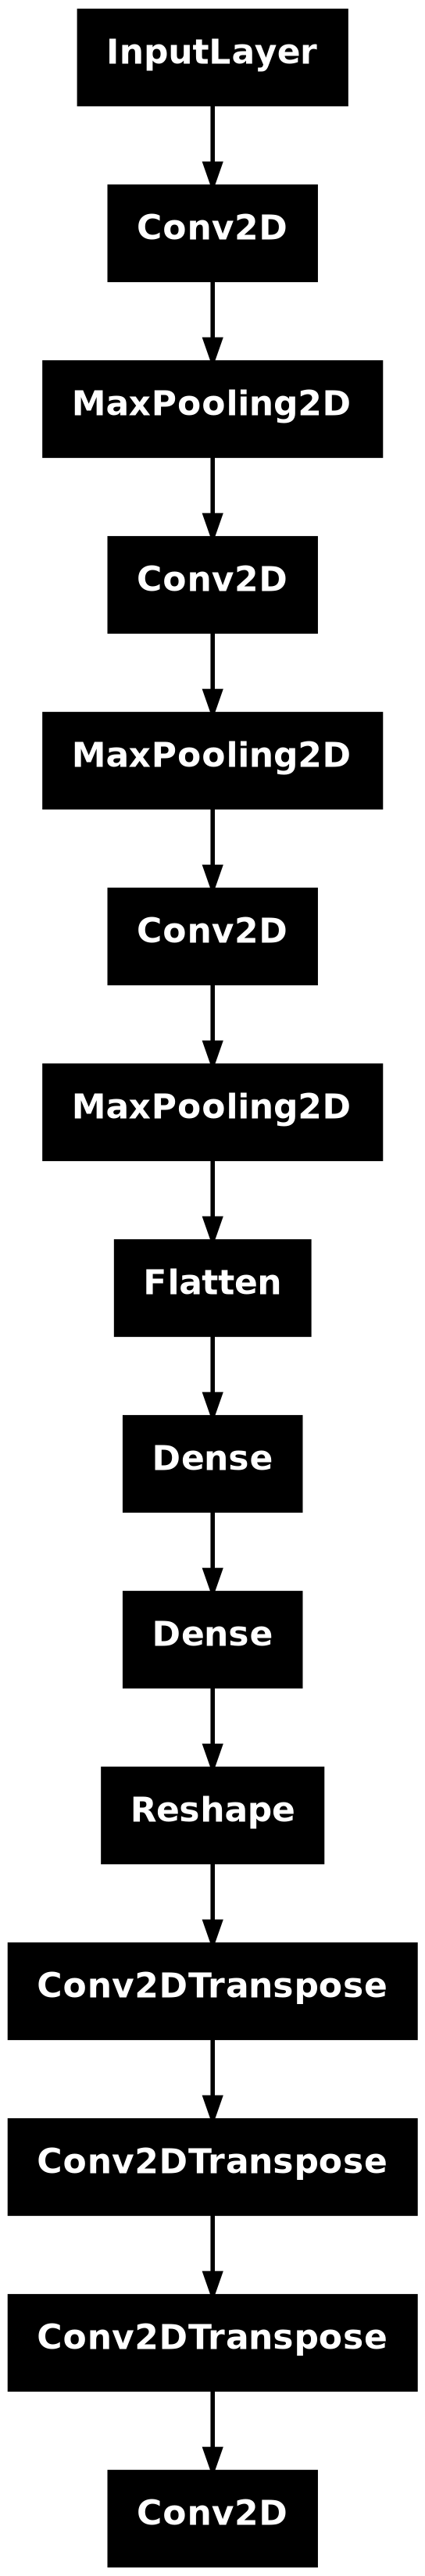

In [31]:
# Save autoencoder
autoencoder.save(os.path.join(Config.experiments_path, "autoencoder_no_train.keras"))
keras.utils.plot_model(autoencoder, os.path.join(Config.experiments_path, "autoencoder.png"), show_shapes=True)
keras.utils.plot_model(autoencoder, os.path.join(Config.experiments_path, "autoencoder_no_shapes.png"), show_shapes=False)

In [12]:
def perform_tsne_and_clustering(encoder, dataset, n_clusters, experiments_path):
    # Extract embeddings using encoder
    embeddings = []
    for images, _ in dataset.unbatch():
        embeddings.append(encoder.predict(images[np.newaxis, ...]))
    embeddings = np.concatenate(embeddings, axis=0)

    # Apply TSNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_embeddings)

    # Save embeddings and cluster labels
    np.save(os.path.join(experiments_path, "tsne_embeddings.npy"), tsne_embeddings)
    np.save(os.path.join(experiments_path, "cluster_labels.npy"), cluster_labels)

    # Plot t-SNE results
    plt.figure(figsize=(10, 8))
    for cluster in range(n_clusters):
        cluster_points = tsne_embeddings[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.6)
    plt.legend()
    plt.title("t-SNE Clustering")
    plt.savefig(os.path.join(experiments_path, "tsne_clustering.png"))
    plt.show()

    return tsne_embeddings, cluster_labels

In [21]:
# Construindo o modelo
autoencoder, encoder = build_autoencoder(
    (Config.imgsz, Config.imgsz, 3), Config.encoding_dim)
autoencoder.compile(optimizer="adam", loss="mse")

tuplify = lambda x, n: (x, ) * n
duplify = lambda x: tuplify(x, 2)

# Carregando o dataset
train_dataset = image_dataset_from_directory(
    Config.dataset_path,
    labels=None,
    image_size=(Config.imgsz, Config.imgsz),
    batch_size=Config.batch_size,
    shuffle=True
).map(lambda x: duplify(x / 255.0))

Found 956 files.


In [25]:
# Treinamento com EarlyStopping
early_stopping = EarlyStopping(
    monitor="loss",  # Monitora a métrica de perda
    patience=Config.patience,
    restore_best_weights=True  # Restaura os pesos da melhor época
)

steps_per_epoch = len(train_dataset) // Config.batch_size

# Treinando o modelo
autoencoder.fit(
    train_dataset.repeat(),
    epochs=Config.epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping]
)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021
Epoch 9/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019
Epoch 10/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036
Epoch 11/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 12/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035
Epoch 13/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020
Epoch 14/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022
Epoch 15/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

Extraindo Embeddings: 100%|██████████| 956/956 [01:30<00:00, 10.55it/s]


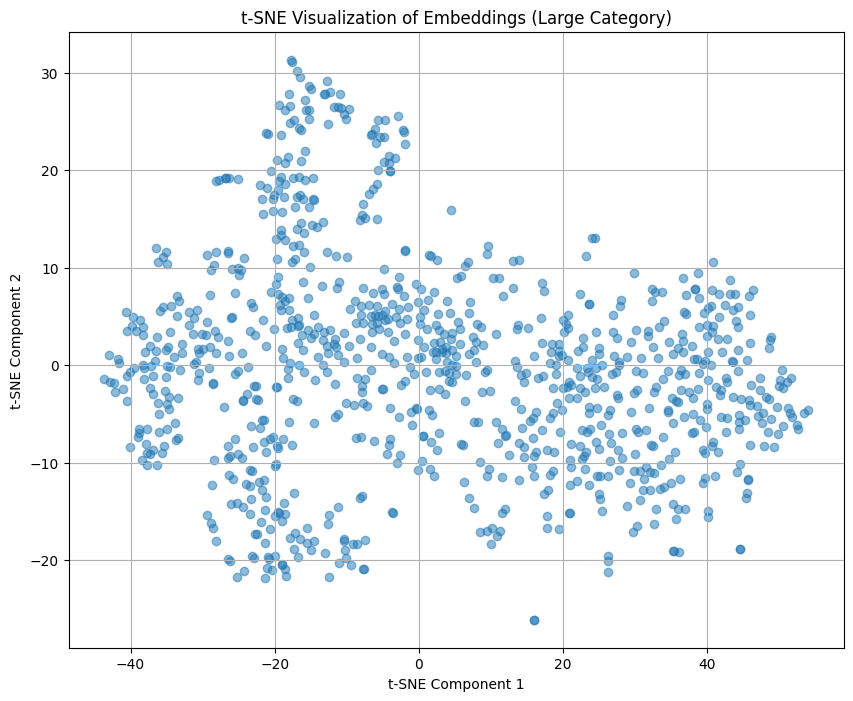

t-SNE Points:
[[-14.345146  -1.557259]
 [ 17.070246   8.395435]
 [ 40.079243 -15.566993]
 ...
 [  6.290882 -11.977124]
 [ 40.64041   -8.280543]
 [ 39.376453 -12.104791]]


In [30]:
# Extração de embeddings com progresso usando tqdm
embeddings = []
# Converte para iterador NumPy
dataset_iterator = train_dataset.unbatch().as_numpy_iterator()
total_images = len(list(train_dataset.unbatch()))  # Conta o total de imagens

for image_pair in tqdm(dataset_iterator, total=total_images, desc="Extraindo Embeddings"):
    image = image_pair[0]  # Extrai a imagem (primeiro elemento do par)
    # Adiciona dimensão de batch
    embeddings.append(encoder.predict(image[tf.newaxis, ...], verbose=0))

embeddings = np.vstack(embeddings)

# TSNE e visualização
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Visualizar t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of Embeddings (Large Category)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid()
plt.show()

# Imprimindo os pontos do t-SNE
print("t-SNE Points:")
print(tsne_embeddings)

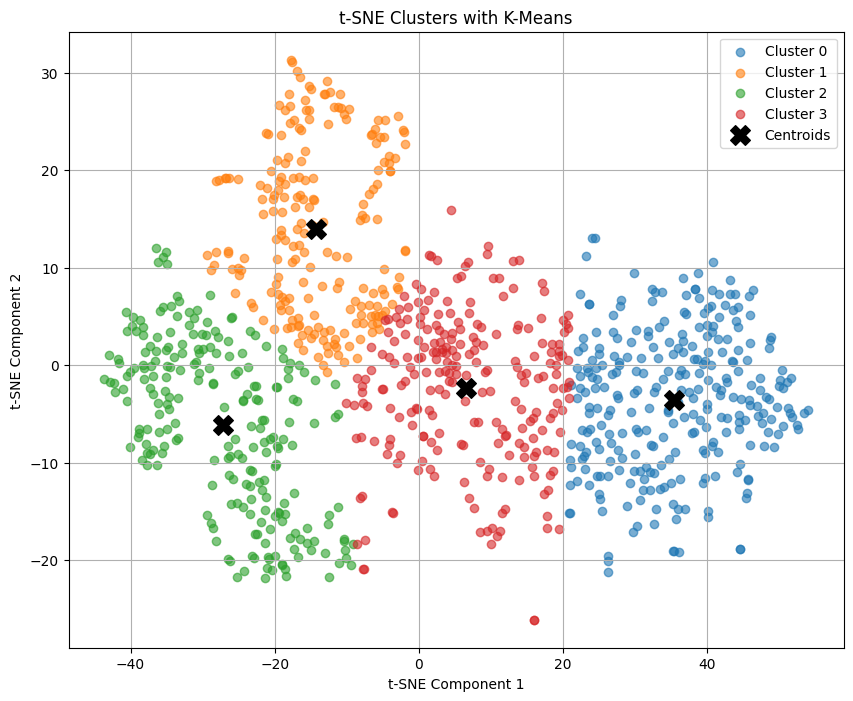

Cluster 0: 283 points
Cluster 1: 206 points
Cluster 2: 230 points
Cluster 3: 237 points


In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Clusterização com K-Means
n_clusters = 4  # Número de clusters desejado
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_embeddings)

# Visualizar os clusters
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_points = tsne_embeddings[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                label=f"Cluster {cluster}", alpha=0.6)

# Marcar os centróides
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=200,
            c="black", marker="X", label="Centroids")

# Configurar o gráfico
plt.title("t-SNE Clusters with K-Means")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid()
plt.show()

# Exibir as informações dos clusters
for cluster in range(n_clusters):
    print(f"Cluster {cluster}: {np.sum(cluster_labels == cluster)} points")

2024-12-31 15:14:15.906488: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


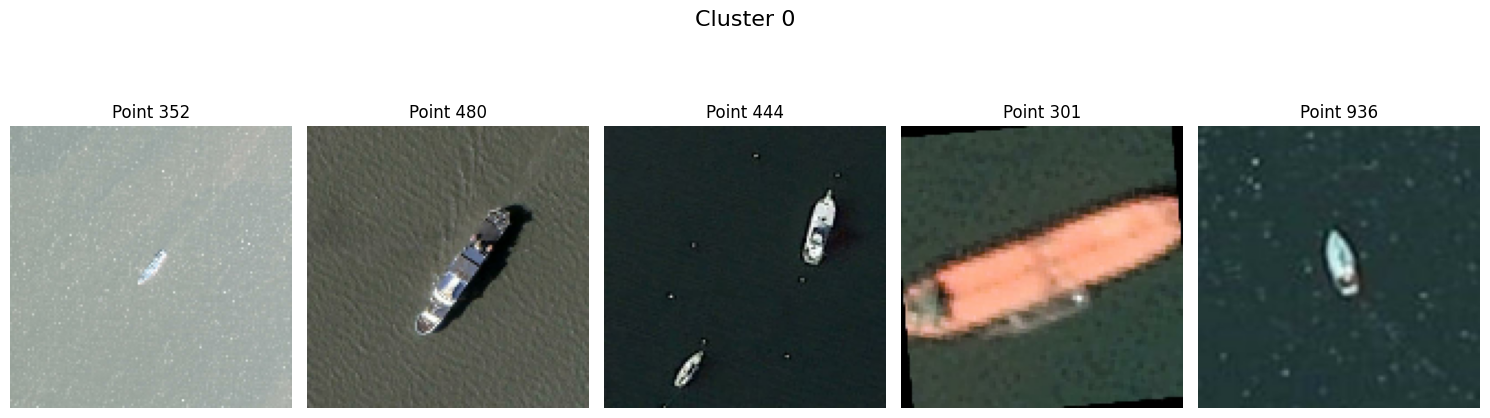

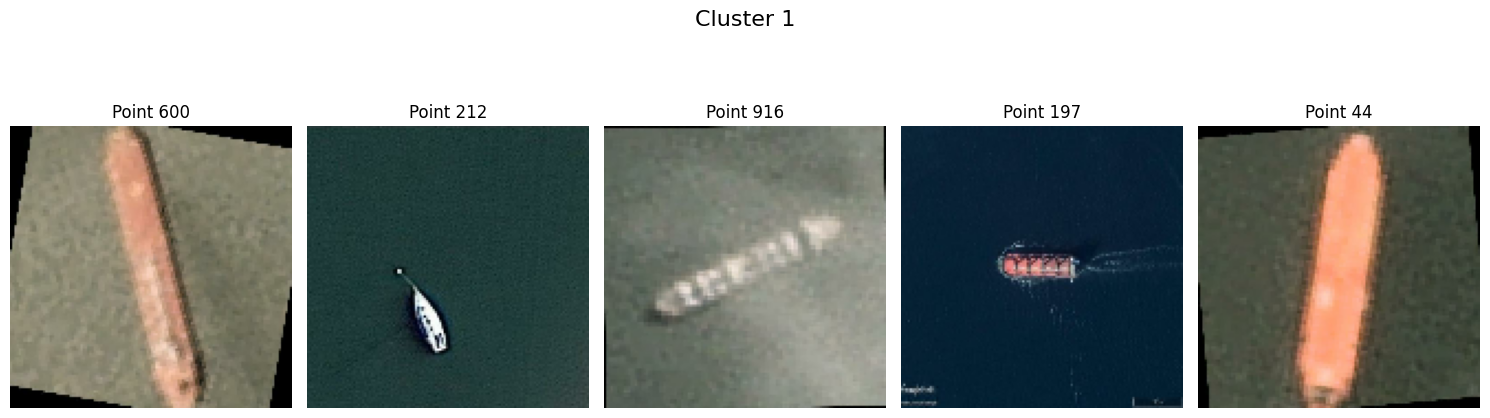

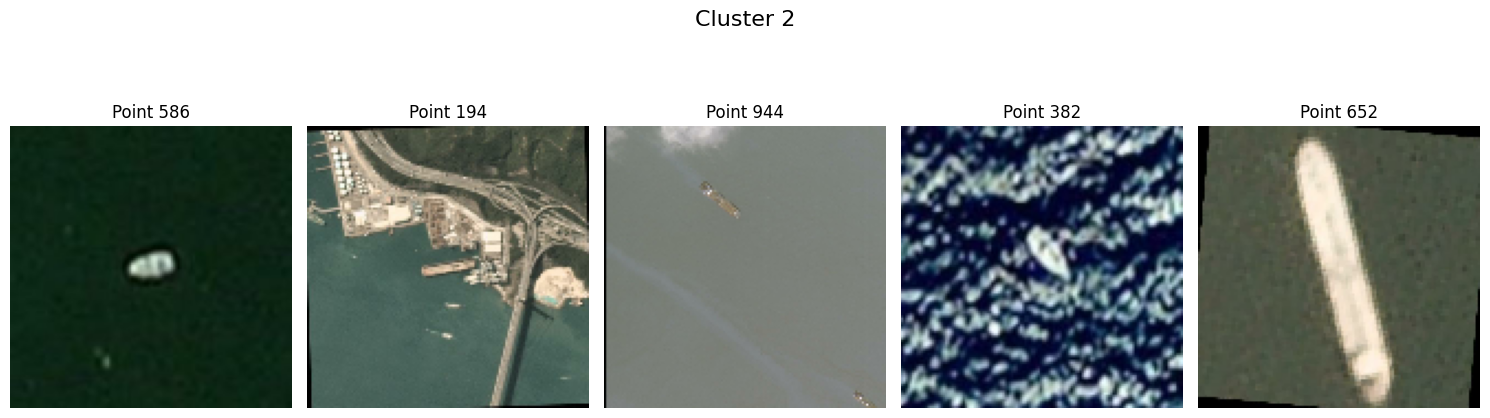

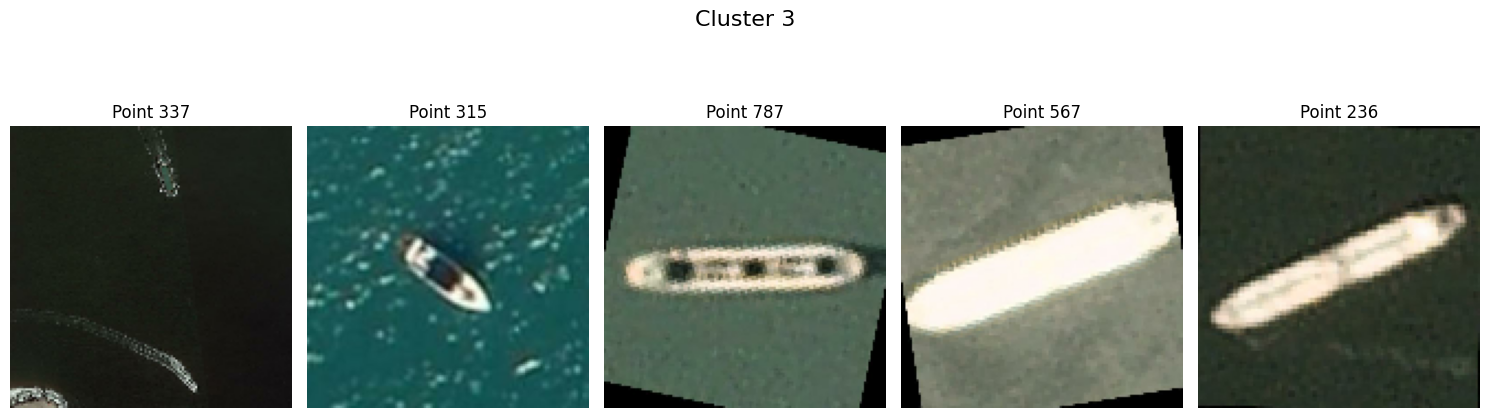

In [ ]:
def show_cluster_examples(dataset, tsne_embeddings, cluster_labels, n_examples=5):
    """
    Mostra exemplos de imagens pertencentes a cada cluster.
    
    Args:
    - dataset: Dataset original usado para t-SNE (formato (input, input)).
    - tsne_embeddings: Embeddings do t-SNE (array de shape (N, 2)).
    - cluster_labels: Rótulos dos clusters gerados (array de shape (N,)).
    - n_examples: Número de exemplos para mostrar de cada cluster.
    """
    unique_clusters = np.unique(cluster_labels)
    # Convertendo o dataset para iterador NumPy
    dataset_iterator = dataset.unbatch().as_numpy_iterator()

    # Carregar todas as imagens para acesso rápido
    # Usar apenas as imagens de entrada
    all_images = [pair[0] for pair in dataset_iterator]
    all_images = np.array(all_images)

    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, min(
            n_examples, len(cluster_indices)), replace=False)

        # Mostrar exemplos do cluster
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Cluster {cluster}", fontsize=16)

        for i, idx in enumerate(selected_indices):
            plt.subplot(1, n_examples, i + 1)
            plt.imshow(all_images[idx])
            plt.title(f"Point {idx}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


# Exibir exemplos de cada cluster
show_cluster_examples(train_dataset, tsne_embeddings,
                      cluster_labels, n_examples=5)